**Getting the data:**
First, let's fetch the cats vs. dogs dataset using TFDS. Tansfer learning is most useful when working with very small datases. To keep our dataset small, we will use 40% of the original training data (25,000 images) for training, 10% for validation, and 10% for testing.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


These are the first 9 images in the training dataset -- as you can see, they're all different sizes. We can also see that label 1 is "dog" and label 0 is "cat".

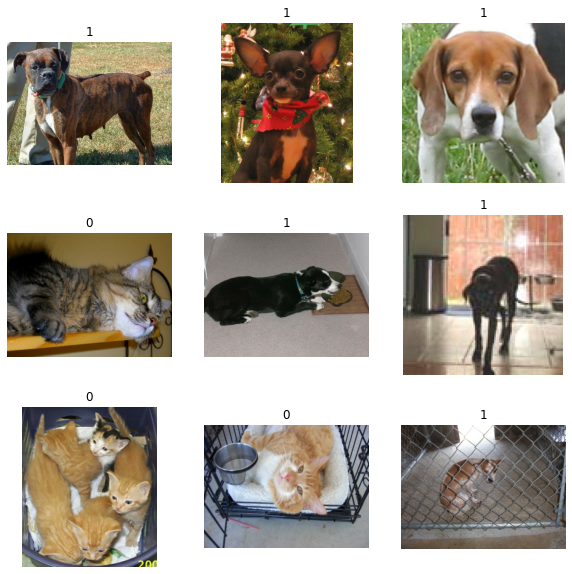

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

**Standardizing the data:** Our raw images have a variety of sizes. This isn't a great fit for feeding a neural network. Standardize to a fixed image size. We pick 150x150.

In [ ]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

Besides, let's batch the data and use caching & prefetching to optimize loading speed.

In [ ]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

**Using random data augmentation:** When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

Let's visualize what the first image of the first batch looks like after various random transformations:

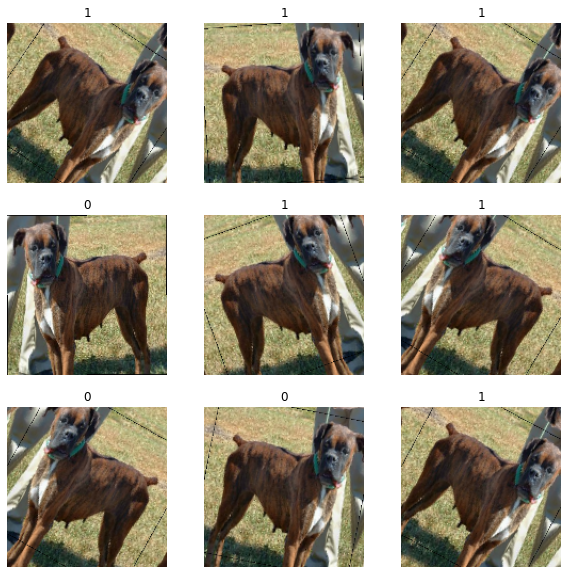

In [ ]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

**Build a model:**

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation


# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

**Train the top layer**

In [ ]:

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
hist = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)


Epoch 1/10
291/291 [==============================] - 24s 82ms/step - loss: 0.1661 - binary_accuracy: 0.9255 - val_loss: 0.0882 - val_binary_accuracy: 0.9669
Epoch 2/10
291/291 [==============================] - 22s 77ms/step - loss: 0.1174 - binary_accuracy: 0.9505 - val_loss: 0.0842 - val_binary_accuracy: 0.9708
Epoch 3/10
291/291 [==============================] - 23s 79ms/step - loss: 0.1163 - binary_accuracy: 0.9511 - val_loss: 0.0815 - val_binary_accuracy: 0.9703
Epoch 4/10
291/291 [==============================] - 23s 78ms/step - loss: 0.1012 - binary_accuracy: 0.9588 - val_loss: 0.0845 - val_binary_accuracy: 0.9699
Epoch 5/10
291/291 [==============================] - 23s 78ms/step - loss: 0.1026 - binary_accuracy: 0.9580 - val_loss: 0.0794 - val_binary_accuracy: 0.9682
Epoch 6/10
291/291 [==============================] - 23s 78ms/step - loss: 0.1033 - binary_accuracy: 0.9573 - val_loss: 0.0885 - val_binary_accuracy: 0.9652
Epoch 7/10
291/291 [==============================] 

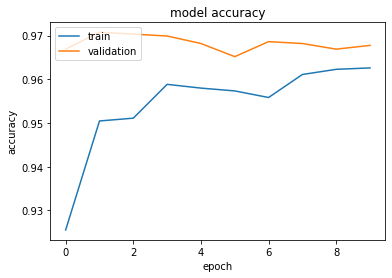

In [ ]:
import matplotlib.pyplot as plt
def plot_hist(hist):
    plt.plot(hist.history["binary_accuracy"])
    plt.plot(hist.history["val_binary_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

**Evaluation on the test set:**

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
73/73 [==============================] - 4s 60ms/step - loss: 0.0764 - binary_accuracy: 0.9729
test loss, test acc: [0.07640572637319565, 0.9729148745536804]


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

291/291 [==============================] - 89s 306ms/step - loss: 0.1100 - binary_accuracy: 0.9551 - val_loss: 0.0555 - val_binary_accuracy: 0.9798
Epoch 2/10
291/291 [==============================] - 88s 301ms/step - loss: 0.0712 - binary_accuracy: 0.9737 - val_loss: 0.0635 - val_binary_accuracy: 0.9721
Epoch 3/10
291/291 [==============================] - 88s 302ms/step - loss: 0.0560 - binary_accuracy: 0.9786 - val_loss: 0.0611 - val_binary_accuracy: 0.9776
Epoch 4/10
291/291 [==============================] - 88s 301ms/step - loss: 0.0473 - binary_accuracy: 0.9809 - val_loss: 0.0569 - val_binary_accuracy: 0.9811
Epoch 5/10
291/291 [==============================] - 87s 300ms/step - loss: 0.0441 - binary_accuracy: 0.9832 - val_loss: 0.0443 - val_binary_accuracy: 0.9824
Epoch 6/10
291/291 [==============================] - 87s 301ms/step - loss: 0.0347 - binary_accuracy: 0.9870 - val_loss: 0.0495 - val_binary_accuracy: 0.9850
Epoch 7/10
291/291 [==============================] - 87s

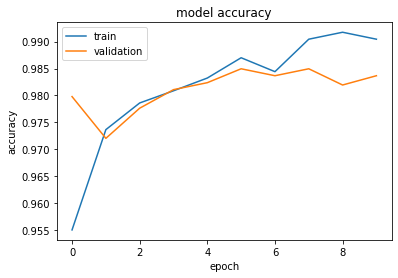

Evaluate on New test data
73/73 [==============================] - 4s 59ms/step - loss: 0.0873 - binary_accuracy: 0.9742
test loss, test acc: [0.08731164038181305, 0.9742046594619751]


In [ ]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),  
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
hist1 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)
plot_hist(hist1)

print("Evaluate on New test data")
results = model.evaluate(test_ds, batch_size=128)
print("test loss, test acc:", results)

Epoch 1/10


291/291 - 87s - loss: 0.0230 - binary_accuracy: 0.9917 - val_loss: 0.0487 - val_binary_accuracy: 0.9850
Epoch 2/10
291/291 - 87s - loss: 0.0190 - binary_accuracy: 0.9933 - val_loss: 0.0528 - val_binary_accuracy: 0.9837
Epoch 3/10
291/291 - 86s - loss: 0.0183 - binary_accuracy: 0.9934 - val_loss: 0.0442 - val_binary_accuracy: 0.9854
Epoch 4/10
291/291 - 86s - loss: 0.0190 - binary_accuracy: 0.9932 - val_loss: 0.0808 - val_binary_accuracy: 0.9635
Epoch 5/10
291/291 - 86s - loss: 0.0197 - binary_accuracy: 0.9930 - val_loss: 0.1484 - val_binary_accuracy: 0.9725
Epoch 6/10
291/291 - 86s - loss: 0.0244 - binary_accuracy: 0.9908 - val_loss: 0.0626 - val_binary_accuracy: 0.9815
Epoch 7/10
291/291 - 86s - loss: 0.0129 - binary_accuracy: 0.9962 - val_loss: 0.0441 - val_binary_accuracy: 0.9862
Epoch 8/10
291/291 - 86s - loss: 0.0105 - binary_accuracy: 0.9957 - val_loss: 0.0835 - val_binary_accuracy: 0.9755
Epoch 9/10
291/291 - 86s - loss: 0.0097 - binary_accuracy: 0.9965 - val_loss: 0.0900 - val_

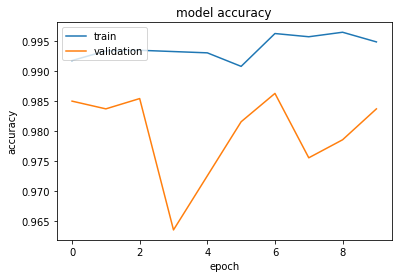

In [ ]:
hist = model.fit(train_ds, epochs=epochs, validation_data=validation_ds, verbose=2)
plot_hist(hist)